In [1]:
import pyarrow.orc as orc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import optuna
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, average_precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Define the file path
path = r'C:/BigData/ProjectStaging/dataExport/fraud_mart_final.orc'

# 2. Load the file using PyArrow
orc_file = orc.ORCFile(path)

# 3. Read the table and slice it immediately to 16M rows
# table.slice(offset, length) is memory efficient
table = orc_file.read().slice(0, 16000000)

# 4. Convert to Pandas with "self_destruct" to keep memory footprint low
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Prevents needing one single massive contiguous block of RAM
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(f"Successfully loaded {len(df):,} rows.")
print(df.head())
print(df.info()) # Check memory usage

Successfully loaded 16,000,000 rows.
    transaction_id  user_id  card           merchant_id  label_is_fraud  \
0  61-5-1514771820       61     5   1799189980464955940               0   
1  61-5-1514894100       61     5  -4169251800658106093               0   
2  61-5-1515899580       61     5  -4752064311331295725               0   
3  61-5-1516172520       61     5   6455213054093379528               0   
4  61-5-1516275060       61     5  -4169251800658106093               0   

  amount  hour_of_day use_chip  merchant_category error_code  \
0   6.39            7     Chip               5499        N/A   
1  29.11           17     Chip               5812        N/A   
2  14.90            8     Chip               4214        N/A   
3  18.77           12   Online               5815        N/A   
4  34.77           17     Chip               5812        N/A   

   credit_utilization  state_mismatch  current_age yearly_income_person  \
0            0.000215               0           63  

### TIME EXTRACTION & SORTING

In [3]:
print("Step 1: extracting timestamps and sorting...")

import gc

# 1. Extract Unix Timestamp from transaction_id (Format: User-Card-Timestamp)
# taking the last part of the string '61-5-1514771820' -> '1514771820'
df['unix_time'] = df['transaction_id'].str.split('-').str[-1].astype(int)

# 2. Convert to Datetime object
df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 3. Sort by Time (Oldest -> Newest) to respect Time Series nature
df.sort_values('datetime', inplace = True)

# 4. Reset index IN-PLACE
df.reset_index(drop=True, inplace=True)

gc.collect()

df.head(5)

Step 1: extracting timestamps and sorting...


,transaction_id,user_id,card,merchant_id,label_is_fraud,amount,hour_of_day,use_chip,merchant_category,error_code,credit_utilization,state_mismatch,current_age,yearly_income_person,fico_score,card_type,card_brand,unix_time,datetime
0,791-1-662780400,791,1,2027553650310142703,0,68.00,7,Swipe,5541,N/A,0.002006,0,58,72510.00,727,Credit,Amex,662780400,1991-01-02 01:40:00
1,791-1-662780820,791,1,2027553650310142703,0,-68.00,7,Swipe,5541,N/A,-0.002006,0,58,72510.00,727,Credit,Amex,662780820,1991-01-02 01:47:00
2,791-1-662781060,791,1,2027553650310142703,0,113.62,7,Swipe,5541,N/A,0.003352,0,58,72510.00,727,Credit,Amex,662781060,1991-01-02 01:51:00
3,791-1-662817600,791,1,-7269691894846892021,0,114.73,17,Swipe,5411,N/A,0.003384,0,58,72510.00,727,Credit,Amex,662817600,1991-01-02 12:00:00
4,791-1-662873580,791,1,-3693650930986299431,0,251.71,9,Swipe,4814,N/A,0.007425,0,58,72510.00,727,Credit,Amex,662873580,1991-01-03 03:33:00


### FEATURE ENGINEERING (Time-Aware)

In [4]:
print("Step 2: Memory-Surgical Feature Engineering...")

# 1. Convert Decimal 'amount' to float32 immediately
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').astype(np.float32)

# 2. Convert Objects (Strings) to Categories
for col in ['use_chip', 'card_type', 'error_code', 'merchant_category']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# 3. Extract Time Components & Cyclical Encoding
df['hour_of_day'] = df['datetime'].dt.hour.astype(np.int8)
df['day_of_week'] = df['datetime'].dt.dayofweek.astype(np.int8)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24).astype(np.float32)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7).astype(np.float32)
df.drop(columns=['hour_of_day', 'day_of_week'], inplace=True)
gc.collect()

# 4. FIXED: Memory-Surgical 'trans_last_24h' (Velocity)
print("Calculating Velocity (trans_last_24h) using NumPy...")
df.sort_values(['user_id', 'unix_time'], inplace=True)

user_ids = df['user_id'].values
unix_times = df['unix_time'].values
velocity_counts = np.zeros(len(df), dtype=np.int16)

# Find where each user's data starts and ends
user_changes = np.where(user_ids[:-1] != user_ids[1:])[0] + 1
user_starts = np.insert(user_changes, 0, 0)
user_ends = np.append(user_changes, len(df))

# Loop over each user (Efficient because it doesn't copy the DF)
for start, end in zip(user_starts, user_ends):
    user_time_window = unix_times[start:end]
    # For every transaction, find how many happened in the previous 86400 seconds
    # searchsorted is extremely fast (logarithmic time)
    lookback_indices = np.searchsorted(user_time_window, user_time_window - 86400, side='left')
    velocity_counts[start:end] = (np.arange(len(user_time_window)) - lookback_indices + 1).astype(np.int16)

df['trans_last_24h'] = velocity_counts
del user_ids, unix_times, velocity_counts, user_starts, user_ends, user_changes
gc.collect()

# 5. Time Since Last Transaction (Speed)
df['time_since_last_trans'] = df['unix_time'].diff().fillna(0).astype(np.float32)
user_changed = df['user_id'] != df['user_id'].shift(1)
df.loc[user_changed, 'time_since_last_trans'] = 0
del user_changed
gc.collect()

# 6. Amount Behavioral Features
print("Calculating user behavioral stats...")
user_medians = df.groupby('user_id')['amount'].transform('median').astype(np.float32)
df['diff_from_median'] = (df['amount'] - user_medians).astype(np.float32)
df['amount_ratio'] = (df['amount'] / (user_medians + 1)).astype(np.float32)
del user_medians
gc.collect()

# 7. Final Projection to save memory
cols_to_keep = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'state_mismatch', 'time_since_last_trans', 'hour_sin', 
    'hour_cos', 'day_sin', 'day_cos', 'diff_from_median', 'amount_ratio',
    'trans_last_24h', 'use_chip', 'card_type', 'error_code', 'merchant_category', 
    'label_is_fraud', 'unix_time'
]
df = df[cols_to_keep]
gc.collect()

print("Step 2 Finished successfully with zero memory leaks.")

Step 2: Memory-Surgical Feature Engineering...
Calculating Velocity (trans_last_24h) using NumPy...
Calculating user behavioral stats...
Step 2 Finished successfully with zero memory leaks.


### Temporal Splitting and Target Encoding

In [5]:
print("Step 3: Preparing Data for Splitting...")

# 1. Recover 'datetime' if it was dropped during memory optimization
if 'datetime' not in df.columns and 'unix_time' in df.columns:
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

# 2. Global Temporal Sort (Ensures Test = Future transactions)
# We sort by unix_time as it's faster than sorting by datetime objects
df.sort_values('unix_time', inplace=True)
df.reset_index(drop=True, inplace=True)

# 3. Define Temporal Split (80% Train, 10% Val, 10% Test)
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Print timing info to verify the split is chronological
print(f"--- Temporal Split Verification ---")
print(f"Train Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"Val   Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"Test  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

# 4. Target Encoding for Merchant Category (Crucial: Use ONLY Training labels)
print("\nTarget encoding merchant_category...")
mcc_map = train_df.groupby('merchant_category')['label_is_fraud'].mean()
global_mean = train_df['label_is_fraud'].mean()

# Map the fraud risk scores and convert to float32 for memory efficiency
for d in [train_df, val_df, test_df]:
    d['mcc_risk'] = d['merchant_category'].map(mcc_map).fillna(global_mean).astype(np.float32)

# 5. Feature Selection
numeric_features = [
    'amount', 'credit_utilization', 'current_age', 'yearly_income_person', 
    'fico_score', 'trans_last_24h', 'amount_ratio', 'state_mismatch',
    'time_since_last_trans', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'mcc_risk', 'diff_from_median'
]
categorical_features = ['use_chip', 'card_type', 'error_code']

X_train = train_df[numeric_features + categorical_features]
y_train = train_df['label_is_fraud']

X_val = val_df[numeric_features + categorical_features]
y_val = val_df['label_is_fraud']

X_test = test_df[numeric_features + categorical_features]
y_test = test_df['label_is_fraud']

# 6. Final Memory Clean up: Delete the original massive dataframe
del df
gc.collect()

print("\nStep 3 Complete. Train, Val, and Test sets are ready.")

Step 3: Preparing Data for Splitting...
--- Temporal Split Verification ---
Train Period: 1991-01-02 01:40:00 to 2017-04-17 04:45:00
Val   Period: 2017-04-17 04:46:00 to 2018-09-26 14:24:00
Test  Period: 2018-09-26 14:24:00 to 2020-02-28 18:28:00

Target encoding merchant_category...

Step 3 Complete. Train, Val, and Test sets are ready.


### creating an autoencoder to learn what normal transaction looks like

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import numpy as np
import gc

# --- Define X_train_normal ---
# We train the Autoencoder ONLY on non-fraudulent data (label 0)
X_train_normal = X_train[y_train == 0]
print(f"Training set filtered to {len(X_train_normal):,} normal transactions.")

# 1. Define the preprocessor
preprocessor_ae = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
])

# 2. Fit on a sample
print("Fitting preprocessor on sample...")
sample_size = min(1000000, len(X_train_normal))
preprocessor_ae.fit(X_train_normal.sample(sample_size, random_state=42))

# 3. FIX 2: Memory-Optimized Chunked Transform (Pre-allocation)
def chunked_transform(data, transformer, chunk_size=500000):
    n_rows = data.shape[0]
    # Inferred output dimensions (numeric + categorical features)
    n_cols = len(numeric_features) + len(categorical_features)
    
    # Pre-allocate the entire array at once to avoid the np.vstack memory spike
    print(f"Pre-allocating buffer for {n_rows} rows...")
    result = np.empty((n_rows, n_cols), dtype=np.float32)
    
    for i in range(0, n_rows, chunk_size):
        end = min(i + chunk_size, n_rows)
        chunk = data.iloc[i:end]
        # Fill the pre-allocated array directly
        result[i:end] = transformer.transform(chunk).astype(np.float32)
        
    print("Transformation complete.")
    return result

# Run the transformation
X_train_ae = chunked_transform(X_train_normal, preprocessor_ae)

# 4. Critical RAM Cleanup
# We no longer need X_train_normal as the data is now in X_train_ae
del X_train_normal
gc.collect()

print(f"X_train_ae ready. Shape: {X_train_ae.shape}, Dtype: {X_train_ae.dtype}")


Training set filtered to 12,784,605 normal transactions.
Fitting preprocessor on sample...
Pre-allocating buffer for 12784605 rows...
Transformation complete.
X_train_ae ready. Shape: (12784605, 18), Dtype: float32


In [9]:
# --- Autoencoder Definition ---
input_dim = X_train_ae.shape[1]

# 1. High-Capacity Denoising Autoencoder
class DenoisingAutoencoder(Model):
    def __init__(self, input_dim):
        super(DenoisingAutoencoder, self).__init__()
        # The "Denoising" part: Add noise to inputs to learn robust features
        self.noise = layers.GaussianNoise(0.1) 
        
        # Encoder: Compressing to 8-node bottleneck
        self.encoder = tf.keras.Sequential([
            layers.Dense(input_dim, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu", name="latent_space") # Bottleneck
        ])
        
        # Decoder: Reconstructing the original signal
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(input_dim)
        ])

    def call(self, x, training=False):
        # Only add noise during training
        if training:
            x = self.noise(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    # Helper function to get latent features only
    def get_latent(self, x):
        return self.encoder(x)

autoencoder = DenoisingAutoencoder(X_train_ae.shape[1])
autoencoder.compile(optimizer='adam', loss='mse')

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True
)

# 5. Train on Normal Data
print("Training Autoencoder...")
history = autoencoder.fit(
    X_train_ae, X_train_ae, 
    epochs=50, 
    batch_size=2048, 
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Training Autoencoder...
Epoch 1/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.4678 - val_loss: 0.3710
Epoch 2/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.2473 - val_loss: 0.3183
Epoch 3/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.2123 - val_loss: 0.2943
Epoch 4/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.1936 - val_loss: 0.2857
Epoch 5/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.1897 - val_loss: 0.2841
Epoch 6/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.1845 - val_loss: 0.2821
Epoch 7/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.1821 - val_loss: 0.2697
Epoch 8/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.1707 - val_loss: 0.2526
Epoch 9/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.1251 - val_loss: 0.1920
Epoch 10/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.1011 - val_loss: 0.1877
Epoch 11/50
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0961 - val_loss: 0.

In [11]:
def extract_ae_features_safe(model, pipeline, data, chunk_size=500000):
    """
    Extracts reconstruction error and latent features in chunks 
    to prevent MemoryError on large datasets.
    """
    n_rows = data.shape[0]
    # Initialize output arrays as float32 to save 50% memory
    recon_errors = np.zeros(n_rows, dtype=np.float32)
    latent_feats = np.zeros((n_rows, 8), dtype=np.float32)
    
    print(f"Processing {n_rows:,} rows in chunks of {chunk_size:,}...")
    
    for i in range(0, n_rows, chunk_size):
        end = min(i + chunk_size, n_rows)
        chunk = data.iloc[i:end]
        
        # 1. Transform and force float32 immediately
        X_scaled_chunk = pipeline.transform(chunk).astype('float32')
        
        # 2. Predict reconstructions
        reconstructions = model.predict(X_scaled_chunk, batch_size=4096, verbose=0)
        
        # 3. Calculate MAE Error per row
        recon_errors[i:end] = np.mean(np.abs(X_scaled_chunk - reconstructions), axis=1)
        
        # 4. Extract Latent space (8 nodes)
        latent_feats[i:end] = model.get_latent(X_scaled_chunk).numpy()
        
        # Clean up temporary memory
        del X_scaled_chunk, reconstructions
        if i % (chunk_size * 2) == 0: gc.collect()
            
    return recon_errors, latent_feats

# --- Execution ---

# 1. Process Train
re_train, lat_train = extract_ae_features_safe(autoencoder, preprocessor_ae, X_train)
X_train['recon_error'] = re_train
for i in range(8): X_train[f'lat_{i}'] = lat_train[:, i]
del re_train, lat_train; gc.collect()

# 2. Process Val
re_val, lat_val = extract_ae_features_safe(autoencoder, preprocessor_ae, X_val)
X_val['recon_error'] = re_val
for i in range(8): X_val[f'lat_{i}'] = lat_val[:, i]
del re_val, lat_val; gc.collect()

# 3. Process Test
re_test, lat_test = extract_ae_features_safe(autoencoder, preprocessor_ae, X_test)
X_test['recon_error'] = re_test
for i in range(8): X_test[f'lat_{i}'] = lat_test[:, i]
del re_test, lat_test; gc.collect()

# 4. Update the feature lists for the Supervised Model
ae_cols = ['recon_error'] + [f'lat_{i}' for i in range(8)]
numeric_features.extend(ae_cols)

# IMPORTANT: Remove duplicates if they exist
numeric_features = list(dict.fromkeys(numeric_features))

print(f"\nSUCCESS: Added {len(ae_cols)} features. Dataframe shapes updated.")

Processing 12,800,000 rows in chunks of 500,000...
Processing 1,600,000 rows in chunks of 500,000...
Processing 1,600,000 rows in chunks of 500,000...

SUCCESS: Added 9 features. Dataframe shapes updated.


In [12]:
# Robustly convert all features to numeric for XGBoost
for d in [X_train, X_val, X_test]:
    # 1. Fix 'yearly_income_person' (Object -> Float)
    if 'yearly_income_person' in d.columns:
        d['yearly_income_person'] = pd.to_numeric(d['yearly_income_person'], errors='coerce').astype(np.float32)
    
    # 2. Fix Categorical Features (Object/Category -> Integer Codes)
    for col in categorical_features:
        if col in d.columns:
            # Explicitly cast to category first to avoid AttributeError, then get codes
            d[col] = d[col].astype('category').cat.codes.astype(np.int32)

print("Check dtypes - All should now be int or float:")
print(X_train[categorical_features + ['yearly_income_person']].dtypes)

Check dtypes - All should now be int or float:
use_chip                  int32
card_type                 int32
error_code                int32
yearly_income_person    float32
dtype: object


In [13]:
from sklearn.metrics import average_precision_score

import xgboost as xgb
from sklearn.metrics import average_precision_score

def objective_xgb(trial):
    # Standard ratio for scale_pos_weight
    ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
    
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'scale_pos_weight': ratio,
        'tree_method': 'hist',
        'random_state': 42,
        'early_stopping_rounds':50,
        'verbosity': 0
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],  
        verbose=False
    )
    
    preds_proba = model.predict_proba(X_val)[:, 1]
    return average_precision_score(y_val, preds_proba)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

print(f"\nBest XGBoost AUPRC: {study_xgb.best_value:.4f}")
print("Best Params:", study_xgb.best_params)

[I 2026-01-21 19:57:37,409] A new study created in memory with name: no-name-431776b1-3d52-4572-8d05-4b033bd624ba
[I 2026-01-21 20:04:44,059] Trial 0 finished with value: 0.0037962231880248483 and parameters: {'learning_rate': 0.08449220416052487, 'max_depth': 4, 'subsample': 0.9206702405149937, 'colsample_bytree': 0.9585940300105141, 'gamma': 9.724023050016475e-07}. Best is trial 0 with value: 0.0037962231880248483.
[I 2026-01-21 20:14:25,436] Trial 1 finished with value: 0.003933689797212812 and parameters: {'learning_rate': 0.04778509068952573, 'max_depth': 7, 'subsample': 0.9755125548474644, 'colsample_bytree': 0.6710679453128232, 'gamma': 0.025167201256411777}. Best is trial 1 with value: 0.003933689797212812.
[I 2026-01-21 20:23:25,319] Trial 2 finished with value: 0.0035180034893513715 and parameters: {'learning_rate': 0.05543945121997899, 'max_depth': 6, 'subsample': 0.8067159178787415, 'colsample_bytree': 0.601225497564519, 'gamma': 0.07235273876827658}. Best is trial 1 with v


Best XGBoost AUPRC: 0.0073
Best Params: {'learning_rate': 0.09906262870108117, 'max_depth': 10, 'subsample': 0.6006627391327389, 'colsample_bytree': 0.8309408816759027, 'gamma': 0.1446647666828463}


In [14]:
import lightgbm as lgb
from sklearn.metrics import average_precision_score

def objective_lgb(trial):
    # Calculate the scale_pos_weight ratio similar to your XGBoost approach
    ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': ratio,
        'random_state': 42,
        'verbosity': -1,
        'n_jobs': -1
    }

    model = lgb.LGBMClassifier(**params)

    # In modern LightGBM, early stopping is handled via the callbacks list
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc', # Internal metric to monitor during training
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0) # Keeps the Optuna output clean
        ]
    )

    # Predict probabilities for the Fraud class
    preds_proba = model.predict_proba(X_val)[:, 1]
    
    # Return Average Precision (AUPRC) to Optuna
    return average_precision_score(y_val, preds_proba)

# Create and run the LightGBM study
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=20)

print(f"\nBest LightGBM AUPRC: {study_lgb.best_value:.4f}")
print("Best Params:", study_lgb.best_params)

[I 2026-01-21 23:24:53,465] A new study created in memory with name: no-name-1eafad85-736f-4950-a858-be8f28519861


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.437075	valid_0's binary_logloss: 1.09178


[I 2026-01-21 23:25:26,386] Trial 0 finished with value: 0.0017661840364221382 and parameters: {'learning_rate': 0.08745761715991922, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.8616597759201833, 'colsample_bytree': 0.6906539694272964, 'reg_alpha': 1.0844921004307572e-06, 'reg_lambda': 5.283862288296244e-06}. Best is trial 0 with value: 0.0017661840364221382.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.755334	valid_0's binary_logloss: 1.06109


[I 2026-01-21 23:25:52,932] Trial 1 finished with value: 0.0026319932324012987 and parameters: {'learning_rate': 0.04313650853013871, 'num_leaves': 72, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.5687942404202667, 'colsample_bytree': 0.6938761841594365, 'reg_alpha': 0.0019347933972198221, 'reg_lambda': 0.0003368912204043221}. Best is trial 1 with value: 0.0026319932324012987.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.718433	valid_0's binary_logloss: 0.505756


[I 2026-01-21 23:26:20,060] Trial 2 finished with value: 0.002439721081391723 and parameters: {'learning_rate': 0.028815430681020715, 'num_leaves': 29, 'max_depth': 4, 'min_child_samples': 92, 'subsample': 0.944613644686146, 'colsample_bytree': 0.766613729205827, 'reg_alpha': 0.00011466986718553052, 'reg_lambda': 2.4684422422104005e-07}. Best is trial 1 with value: 0.0026319932324012987.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.531934	valid_0's binary_logloss: 1.27018


[I 2026-01-21 23:26:55,368] Trial 3 finished with value: 0.001127265950729487 and parameters: {'learning_rate': 0.05834523079923729, 'num_leaves': 244, 'max_depth': 8, 'min_child_samples': 75, 'subsample': 0.8061743123202275, 'colsample_bytree': 0.959278306607488, 'reg_alpha': 0.01525328110569735, 'reg_lambda': 9.165216291900407e-06}. Best is trial 1 with value: 0.0026319932324012987.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.822004	valid_0's binary_logloss: 0.46465


[I 2026-01-21 23:27:24,991] Trial 4 finished with value: 0.002876062745165059 and parameters: {'learning_rate': 0.024533478038169382, 'num_leaves': 23, 'max_depth': 9, 'min_child_samples': 35, 'subsample': 0.7504820807952406, 'colsample_bytree': 0.7557285952661663, 'reg_alpha': 0.012506632236078792, 'reg_lambda': 1.4303060939784757e-05}. Best is trial 4 with value: 0.002876062745165059.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.466528	valid_0's binary_logloss: 1.23985


[I 2026-01-21 23:27:57,218] Trial 5 finished with value: 0.0017644058021530648 and parameters: {'learning_rate': 0.08264482241490922, 'num_leaves': 245, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9083490124089155, 'colsample_bytree': 0.5136351944508124, 'reg_alpha': 2.394570124747143e-07, 'reg_lambda': 4.4541301379841784e-05}. Best is trial 4 with value: 0.002876062745165059.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.333257	valid_0's binary_logloss: 0.809189


[I 2026-01-21 23:28:23,603] Trial 6 finished with value: 0.001480177610109544 and parameters: {'learning_rate': 0.09611316955807608, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 81, 'subsample': 0.8878161797027042, 'colsample_bytree': 0.5781804357581626, 'reg_alpha': 6.534252416996364e-08, 'reg_lambda': 2.3590012950598298e-08}. Best is trial 4 with value: 0.002876062745165059.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.599872	valid_0's binary_logloss: 0.625523


[I 2026-01-21 23:29:04,658] Trial 7 finished with value: 0.0017553422271732594 and parameters: {'learning_rate': 0.03615698379143739, 'num_leaves': 215, 'max_depth': 8, 'min_child_samples': 97, 'subsample': 0.6356558415113622, 'colsample_bytree': 0.8074729550744079, 'reg_alpha': 6.58425066349923e-07, 'reg_lambda': 0.0016226808549257591}. Best is trial 4 with value: 0.002876062745165059.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.805861	valid_0's binary_logloss: 0.244844


[I 2026-01-21 23:29:48,007] Trial 8 finished with value: 0.002693452169003694 and parameters: {'learning_rate': 0.016050586908846018, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.6976581991290802, 'colsample_bytree': 0.6180148733523049, 'reg_alpha': 5.621088079450968e-06, 'reg_lambda': 5.926830616201589e-08}. Best is trial 4 with value: 0.002876062745165059.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.764811	valid_0's binary_logloss: 0.0858329


[I 2026-01-21 23:30:33,678] Trial 9 finished with value: 0.002659585162061222 and parameters: {'learning_rate': 0.011441844117384765, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 58, 'subsample': 0.9384611612197032, 'colsample_bytree': 0.8811595690241631, 'reg_alpha': 2.790255468105865e-08, 'reg_lambda': 1.4939743441435082e-07}. Best is trial 4 with value: 0.002876062745165059.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.786033	valid_0's binary_logloss: 0.460381


[I 2026-01-21 23:31:17,858] Trial 10 finished with value: 0.002245741791769243 and parameters: {'learning_rate': 0.02156613137090007, 'num_leaves': 161, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.7512625591436134, 'colsample_bytree': 0.9997606307018041, 'reg_alpha': 8.879030898642648, 'reg_lambda': 0.6086602276656037}. Best is trial 4 with value: 0.002876062745165059.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.843563	valid_0's binary_logloss: 0.192412


[I 2026-01-21 23:31:54,170] Trial 11 finished with value: 0.0029055395650490617 and parameters: {'learning_rate': 0.014843237846396294, 'num_leaves': 22, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.6726992408956353, 'colsample_bytree': 0.629377037572494, 'reg_alpha': 3.991372170112033e-05, 'reg_lambda': 0.015161596428841411}. Best is trial 11 with value: 0.0029055395650490617.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.815904	valid_0's binary_logloss: 0.0560716


[I 2026-01-21 23:32:29,079] Trial 12 finished with value: 0.00237565233677782 and parameters: {'learning_rate': 0.010197645978313494, 'num_leaves': 22, 'max_depth': 10, 'min_child_samples': 43, 'subsample': 0.5011176534429026, 'colsample_bytree': 0.6661229645749273, 'reg_alpha': 0.08465489606134384, 'reg_lambda': 0.03512504105615245}. Best is trial 11 with value: 0.0029055395650490617.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.646729	valid_0's binary_logloss: 0.336699


[I 2026-01-21 23:33:21,123] Trial 13 finished with value: 0.0017909513832514146 and parameters: {'learning_rate': 0.01872800237657072, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 38, 'subsample': 0.6852395036055453, 'colsample_bytree': 0.8249557957527539, 'reg_alpha': 0.00023703672745738438, 'reg_lambda': 9.243329585496058}. Best is trial 11 with value: 0.0029055395650490617.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.754369	valid_0's binary_logloss: 0.417002


[I 2026-01-21 23:33:50,285] Trial 14 finished with value: 0.002978303848165015 and parameters: {'learning_rate': 0.026486427364642413, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.7753595560445294, 'colsample_bytree': 0.579619209125009, 'reg_alpha': 0.17339598082351979, 'reg_lambda': 0.022589642032005072}. Best is trial 14 with value: 0.002978303848165015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.80151	valid_0's binary_logloss: 0.199128


[I 2026-01-21 23:34:32,595] Trial 15 finished with value: 0.002588561462559421 and parameters: {'learning_rate': 0.014706330700066259, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 60, 'subsample': 0.8083465905811877, 'colsample_bytree': 0.516256882746138, 'reg_alpha': 1.4416511307334485, 'reg_lambda': 0.015048650168970227}. Best is trial 14 with value: 0.002978303848165015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.799213	valid_0's binary_logloss: 0.143166


[I 2026-01-21 23:35:15,700] Trial 16 finished with value: 0.002402045490401036 and parameters: {'learning_rate': 0.013504652881550405, 'num_leaves': 121, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.6327311053613989, 'colsample_bytree': 0.5829642383016932, 'reg_alpha': 1.9152220882946884e-05, 'reg_lambda': 0.04836080900432621}. Best is trial 14 with value: 0.002978303848165015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.782981	valid_0's binary_logloss: 2.08375


[I 2026-01-21 23:35:50,497] Trial 17 finished with value: 0.0025646093777135746 and parameters: {'learning_rate': 0.04713160496912668, 'num_leaves': 51, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.687423770448364, 'colsample_bytree': 0.6215143621614333, 'reg_alpha': 0.5730357554873957, 'reg_lambda': 0.520001560801957}. Best is trial 14 with value: 0.002978303848165015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.70611	valid_0's binary_logloss: 0.40468


[I 2026-01-21 23:36:33,804] Trial 18 finished with value: 0.0023003779679764743 and parameters: {'learning_rate': 0.02794414961685284, 'num_leaves': 154, 'max_depth': 9, 'min_child_samples': 51, 'subsample': 0.7952822361147202, 'colsample_bytree': 0.5663907167516774, 'reg_alpha': 0.0016259915455569909, 'reg_lambda': 0.002515325706655928}. Best is trial 14 with value: 0.002978303848165015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.791166	valid_0's binary_logloss: 0.280385


[I 2026-01-21 23:37:28,107] Trial 19 finished with value: 0.0026672251480730253 and parameters: {'learning_rate': 0.01743599071294833, 'num_leaves': 196, 'max_depth': 11, 'min_child_samples': 73, 'subsample': 0.9889521555938522, 'colsample_bytree': 0.6516688893362548, 'reg_alpha': 1.470913549170466e-05, 'reg_lambda': 0.3936830649828061}. Best is trial 14 with value: 0.002978303848165015.



Best LightGBM AUPRC: 0.0030
Best Params: {'learning_rate': 0.026486427364642413, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.7753595560445294, 'colsample_bytree': 0.579619209125009, 'reg_alpha': 0.17339598082351979, 'reg_lambda': 0.022589642032005072}


In [16]:
# 1. Define base models WITHOUT early stopping for the stack
# We use the best params found by Optuna but set a fixed n_estimators
base_estimators = [
    ('xgb', xgb.XGBClassifier(
        **study_xgb.best_params, 
        n_estimators=500, # Fixed iterations instead of early stopping
        tree_method='hist',
        random_state=42
    )),
    ('lgb', lgb.LGBMClassifier(
        **study_lgb.best_params, 
        n_estimators=500, # Fixed iterations
        random_state=42,
        verbosity=-1
    ))
]

# 2. Re-initialize the Stack with n_jobs=1 to prevent memory crashes
stack_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    cv=2,          # Keep CV low to save memory on your 16M rows
    n_jobs=1,      # Process sequentially to avoid 'bad allocation' errors
    passthrough=False
)

print("Training the Stacking Classifier with fixed iterations...")
stack_model.fit(X_train, y_train)

# 3. Final Evaluation
print("\n--- Final Evaluation on Test Set ---")
test_probs = stack_model.predict_proba(X_test)[:, 1]
print(f"Final Stacked AUPRC: {average_precision_score(y_test, test_probs):.4f}")

# 5. Display Classification Report
print("\nClassification Report:")
print(classification_report(y_test, test_preds))

# 6. Visualize Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Final Model: Confusion Matrix (Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Training the Stacking Classifier with fixed iterations...

--- Final Evaluation on Test Set ---
Final Stacked AUPRC: 0.0307

Classification Report:


NameError: name 'test_preds' is not defined

Final Stacked AUPRC: 0.0307

Classification Report (Threshold 0.1):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1598476
           1       0.00      0.00      0.00      1524

    accuracy                           1.00   1600000
   macro avg       0.50      0.50      0.50   1600000
weighted avg       1.00      1.00      1.00   1600000



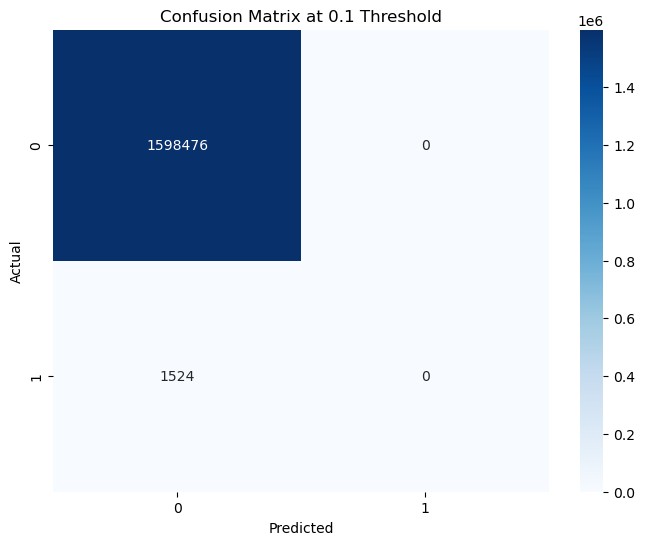

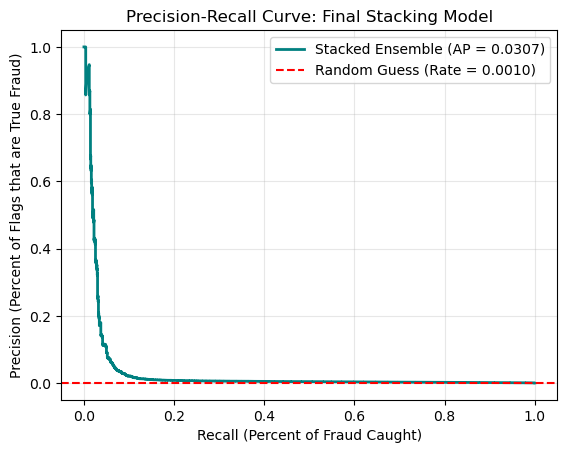

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve

threshold = 0.1 
test_preds = (test_probs >= threshold).astype(int)

# 3. Display Metrics
print(f"Final Stacked AUPRC: {average_precision_score(y_test, test_probs):.4f}")
print("\nClassification Report (Threshold 0.1):")
print(classification_report(y_test, test_preds))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix at 0.1 Threshold')
plt.show()

# Find what threshold gives us the best balance
precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
auprc = average_precision_score(y_test, test_probs)

# 2. Plotting (Following standard notebook visualization)
plt.plot(recall, precision, label=f'Stacked Ensemble (AP = {auprc:.4f})', color='teal', lw=2)

# 3. Add the "No-Skill" Baseline
# In PR curves, the baseline is a horizontal line at the proportion of positive cases
no_skill = sum(y_test) / len(y_test)
plt.axhline(y=no_skill, color='red', linestyle='--', label=f'Random Guess (Rate = {no_skill:.4f})')

# 4. Formatting
plt.xlabel('Recall (Percent of Fraud Caught)')
plt.ylabel('Precision (Percent of Flags that are True Fraud)')
plt.title('Precision-Recall Curve: Final Stacking Model')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.savefig('precision_recall_curve.png') # Saving as per guidelines
plt.show()